# Permutation Feature Importance

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e \
https://medium.com/turo-engineering/how-not-to-use-random-forest-265a19a68576 \
http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

Randomly permute the feature and measure the decrease in accuracy on an out of bag sample

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import pyexcel_xlsx
%pylab inline
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


In [13]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

In [4]:
data = pd.read_excel(r"/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20191021.xlsx")
df = pd.DataFrame(data)
df.set_index('FIPS', inplace=True)

In [6]:
df.columns

Index(['Prop_SFHA_', 'Prop_DG_Ar', 'Ave_LS_cod', 'DG_MaxDe_1', 'HurTrack_D',
       'PeakGust_1', 'MaxSusta_1', 'Count_', 'StrVI', 'SeVI', 'Str+SeVI',
       'SoVI', 'DG_mean_m', 'O_Ind', 'R_Ind', 'R_I_No0', 'R_I_NoO',
       'R_I_No0_NoO', 'cat_3q', 'cat_4q'],
      dtype='object')

In [7]:
df_x = df.drop(['O_Ind', 'R_Ind', 'R_I_No0', 'R_I_NoO',
       'R_I_No0_NoO', 'cat_3q', 'cat_4q'], axis=1)
df_y = df.R_Ind

In [ ]:
features = df_x.columns.values
X = df_x.as_matrix()
Y = df_y.as_matrix()
scores = defaultdict(list)

rf = RandomForestRegressor()

## I should rewrite this code bbelow using methods that I am used to

In [49]:
#crossvalidate the scores on a number of different random splits of the data

for train_idx, test_idx in ShuffleSplit(len(X), 100, .3, random_state=42): #number of splits, absolute number of test samples, proportion of data in train split
    X_train, X_test = X[train_idx], X[test_idx] #Random permutation cross-validator, Yields indices to split data into training and test sets.
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]): #The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i]) #rearranging randomly
        shuff_acc = r2_score(Y_test, rf.predict(X_t)) 
        scores[features[i]].append((acc-shuff_acc)/acc) #change in importance, actual - shuffled/actual, this is percent error


In [80]:
mda_features = [f for f in scores.keys()]
mda_importance = [(np.mean(score)) for score in scores.values()] #average over all the shuffled permutations
mda_indices = np.argsort(mda_importance)

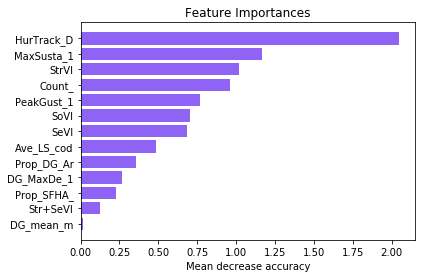

In [62]:
plt.title('Feature Importances')
plt.barh(range(len(mda_indices)), [mda_importance[i] for i in mda_indices], color='#8f63f4', align='center')
plt.yticks(range(len(mda_indices)), [mda_features[i] for i in mda_indices])
plt.xlabel('Mean decrease accuracy')
plt.show()

In [94]:
df_FI = pd.DataFrame({'Feature':mda_features, 'Importance':mda_importance})
df_FI

,Feature,Importance
0,Prop_SFHA_,0.226644
1,Prop_DG_Ar,0.353343
2,Ave_LS_cod,0.482368
3,DG_MaxDe_1,0.268980
4,HurTrack_D,2.050937
5,PeakGust_1,0.767645
6,MaxSusta_1,1.167924
7,Count_,0.958550
8,StrVI,1.017249
9,SeVI,0.683134


In [95]:
df_x.columns

Index(['Prop_SFHA_', 'Prop_DG_Ar', 'Ave_LS_cod', 'DG_MaxDe_1', 'HurTrack_D',
       'PeakGust_1', 'MaxSusta_1', 'Count_', 'StrVI', 'SeVI', 'Str+SeVI',
       'SoVI', 'DG_mean_m'],
      dtype='object')

In [96]:
mda_importance
importances = np.asarray(mda_importance)

In [97]:
indices = np.argsort(importances)[::-1]

In [104]:
label = df_FI.sort_values(by='Importance', ascending=False)

In [106]:
label.Feature

4     HurTrack_D
6     MaxSusta_1
8          StrVI
7         Count_
5     PeakGust_1
11          SoVI
9           SeVI
2     Ave_LS_cod
1     Prop_DG_Ar
3     DG_MaxDe_1
0     Prop_SFHA_
10      Str+SeVI
12     DG_mean_m
Name: Feature, dtype: object

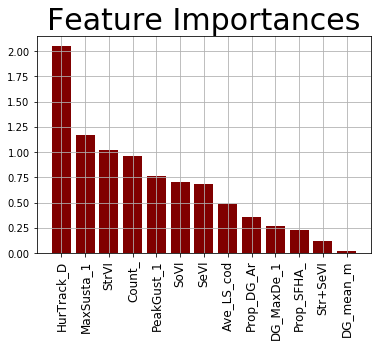

In [115]:
plt.figure()
plt.title("Feature Importances", fontsize = 30)
plt.bar(range(df_FI.shape[0]), importances[indices],
        align="center", color='maroon')

plt.xticks(range(df_FI.shape[0]), label.Feature, fontsize = 12, rotation = 90)
# #plt.xlabel(importance_d.index)
# plt.xlim([-1, x_train.shape[1]])
plt.grid(True)

# plt.savefig('')